In [1]:
# Import ML and Preprocessing libraries
import cv2
import numpy as np
import os
import datetime
from skimage import io
import os
import random
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
# Import Gesture Classes with their respected labeled folders
dataset = glob.glob('data/*')

# Define a list of gesture names
gesture_list = ['blank', 'ok', 'thumbsup', 'thumbsdown', 'fist', 'five']

# Initialize a list to hold loaded images for each class
loaded_images = []

# Initialize the output vectors list
output_vectors = []

# Iterate through each gesture in the gesture list
for gesture_index, gesture in enumerate(gesture_list):
    # Construct the path to the dataset for the current gesture
    gesture_dataset_path = os.path.join("data", gesture)
    # Construct the path to the image files for the current gesture
    gesture_image_path = os.path.join(gesture_dataset_path, '*')
    # Get a list of all image file paths for the current gesture
    gesture_image_file_paths = glob.glob(gesture_image_path)

    # Iterate through each image file path
    for image_file_path in gesture_image_file_paths:
        # Read the image file
        image = cv2.imread(image_file_path)
        # Convert the image to grayscale
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Rotate the image within the range of -45 to 45 degrees
        angle = np.random.randint(-45, 45)      # Randomly select an angle between -45 and 45
        M = cv2.getRotationMatrix2D((grayscale_image.shape[1] // 2, grayscale_image.shape[0] // 2), angle, 1)
        rotated_image = cv2.warpAffine(grayscale_image, M, (grayscale_image.shape[1], grayscale_image.shape[0]))

        # Resize the image
        resized_image = cv2.resize(rotated_image, (120, 120))

        # Append the processed image to the list of loaded images
        loaded_images.append(resized_image)
        # Append the corresponding output vector to the output vectors list
        output_vectors.append(gesture_index)

# Convert the list of loaded images to a numpy array
loaded_images_array = np.array(loaded_images)

# Convert gesture indices to one-hot encoded vectors
output_vectors_array = to_categorical(output_vectors, num_classes=len(gesture_list))

In [4]:
X = np.asarray(loaded_images)
y = np.asarray(output_vectors)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=21)

# Reshape the input images
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

Accuracy: 0.9876483410026641
Confusion Matrix (KNN):
[[637   0   0   0   0   0]
 [  0 654   3   0   1   8]
 [  0   0 682   0   1   0]
 [  0   0   0 646   0   0]
 [  0   0   0   1 702   0]
 [  0   8   0   0  29 757]]
Confusion Matrix (KNN):


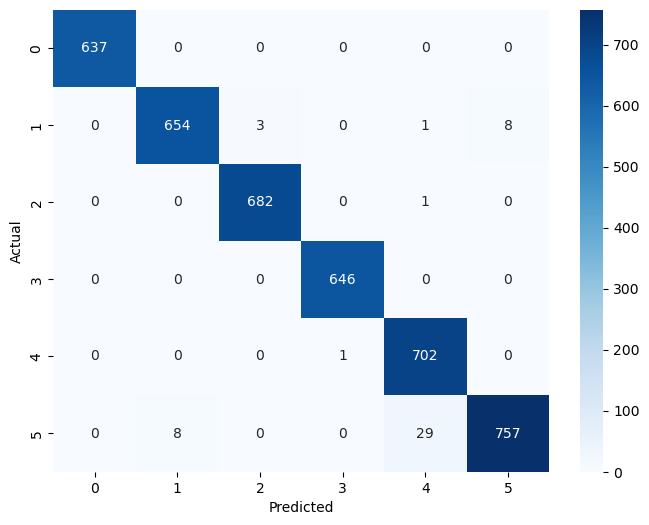

Classification Report (KNN):
              precision    recall  f1-score   support

       blank       1.00      1.00      1.00       637
          ok       0.99      0.98      0.98       666
    thumbsup       1.00      1.00      1.00       683
  thumbsdown       1.00      1.00      1.00       646
        fist       0.96      1.00      0.98       703
        five       0.99      0.95      0.97       794

    accuracy                           0.99      4129
   macro avg       0.99      0.99      0.99      4129
weighted avg       0.99      0.99      0.99      4129



In [6]:
# Best hyperparameters: {'n_neighbors': 2, 'weights': 'distance', 'p': 1}
# KNN Model
knn = KNeighborsClassifier(n_neighbors=2, weights='distance', p=1)

# Train the KNN model
knn.fit(X_train, y_train_encoded)

# Make predictions on the test set
y_pred_knn = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred_knn)
print("Accuracy:", accuracy)

# Compute the confusion matrix
cm_knn = confusion_matrix(y_test_encoded, y_pred_knn)

# Print the confusion matrix
print("Confusion Matrix (KNN):")
print(cm_knn)

# Print the confusion matrix using seaborn
print("Confusion Matrix (KNN):")
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Print the classification report
print("Classification Report (KNN):")
print(classification_report(y_test_encoded, y_pred_knn, target_names=gesture_list))

In [ ]:
# Hyperparameter Tuning: KNN
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Define the parameter distribution
param_distribution = {
    'n_neighbors': [2, 4, 6, 8],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Create an instance of the KNN classifier
knn = KNeighborsClassifier()

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_distribution, 
                                   n_iter=10, scoring='accuracy', cv=3)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train_encoded)

# Get the best hyperparameters
best_params = random_search.best_params_
print("Best hyperparameters:", best_params)

# Create a new KNN classifier with the best hyperparameters
best_knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], 
                                weights=best_params['weights'], p=best_params['p'])

# Train the new KNN model
best_knn.fit(X_train, y_train_encoded)

# Make predictions on the test set using the best model
y_pred_knn = best_knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred_knn)
print("Accuracy:", accuracy)

# Compute the confusion matrix
cm_knn = confusion_matrix(y_test_encoded, y_pred_knn)

# Print the confusion matrix
print("Confusion Matrix (KNN):")
print(cm_knn)

# Print the confusion matrix using seaborn
print("Confusion Matrix (KNN):")
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Print the classification report
print("Classification Report (KNN):")
print(classification_report(y_test_encoded, y_pred_knn, target_names=gesture_list))
